File used for testing the functions in the repository

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import pandas as pd

<h2>Generating simulated data<h2>

In [3]:
from source.Data_generation import DataLoader

In [4]:
# Load the file into a pandas DataFrame
df = pd.read_csv('data/all_data_003.csv')

# Usage example:
data_from_first_row = DataLoader(0, df)

# Output the data extracted from the first row to verify the DataLoader function
print(data_from_first_row)

{'rtim_list': [0.125, 0.291667, 0.375, 0.458333, 0.583333, 0.75, 0.916667, 1.5, 2.5, 3.5, 4.5, 6.25, 8.75, 12.5, 17.5, 25, 35, 45, 55, 65, 75, 85], 'pl_list': [0.05901, 0.0550587, 110.023, 83.0705, 55.6943, 44.4686, 36.9873, 27.5891, 13.5464, 6.33916, 3.52664, 2.49758, 1.44494, 1.04103, 0.71615, 0.52742, 0.43791, 0.35239, 0.32866, 0.27326, 0.26068, 0.24129], 'bl_list': [0.08737, 0.081723, 164.763, 125.181, 84.5654, 68.4428, 58.1711, 44.4919, 24.3138, 14.0272, 9.47834, 7.88443, 5.59859, 4.81384, 3.79608, 3.04436, 2.67881, 2.23747, 2.13455, 1.80559, 1.74821, 1.63998], 'tac_list': [0.125549, 4.5012, 13.7206, 9.70757, 9.24363, 8.84905, 8.37535, 7.8264, 7.84643, 8.74946, 8.4736, 8.5893, 9.00677, 8.93431, 8.7004, 8.79878, 8.63712, 8.86024, 8.56235, 8.77035, 8.93855, 8.96577], 'gt_parameters_list': [0.13, 0.014, 0.025, 0.05]}


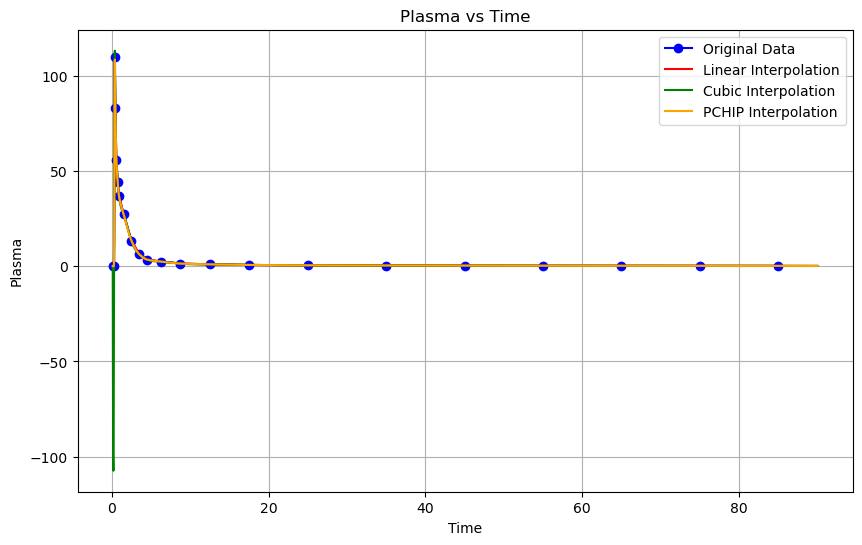

In [5]:
from source.Data_generation import equidistant_interpolation, plot_interpolations

num_equidistant_points = 2048
new_rtim, linear_pl, cubic_pl, pchip_pl = equidistant_interpolation(data_from_first_row['rtim_list'],
                                                          data_from_first_row['pl_list'],
                                                          num_equidistant_points)

plot_interpolations(data_from_first_row['rtim_list'], 
                    data_from_first_row['pl_list'], 
                    new_rtim, linear_pl, cubic_pl, pchip_pl, 'Plasma')

<h3> IRF <h3>

In [6]:
from source.Data_generation import IRF

IRF_values = IRF(data_from_first_row['gt_parameters_list'], new_rtim)


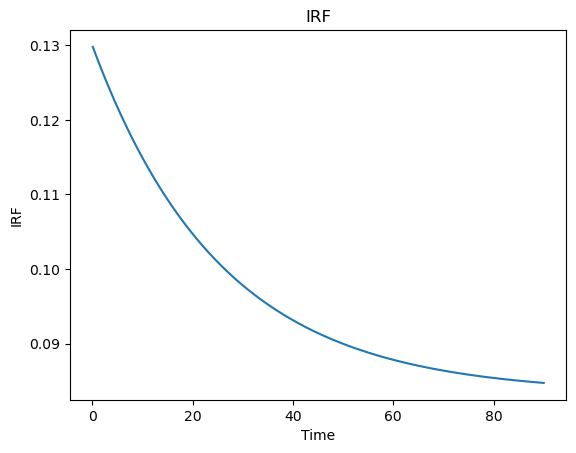

In [7]:
plt.plot(new_rtim, IRF_values)
plt.xlabel('Time')
plt.ylabel('IRF')
plt.title('IRF')
plt.show()

<h2> C Tissue <h2>

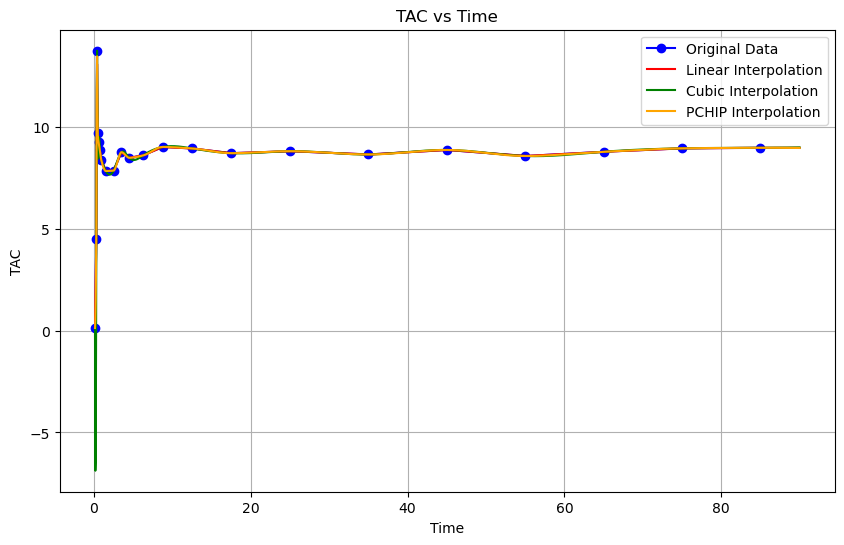

In [8]:
# Get the interpolated tac values
new_rtim, linear_tac, cubic_tac, pchip_tac = equidistant_interpolation(data_from_first_row['rtim_list'],
                                                          data_from_first_row['tac_list'],
                                                          num_equidistant_points)

plot_interpolations(data_from_first_row['rtim_list'], 
                    data_from_first_row['tac_list'], 
                    new_rtim, linear_tac, cubic_tac, pchip_tac, 'TAC')

In [9]:
def c_tissue_torch(IRF_values, pchip_pl, dt):
    """
    Calculates the simulated C_Tissue values for the given IRF and plasma concentration values using PyTorch.

    Parameters:
    IRF_values (list): The IRF values.
    pchip_pl (list): Plasma concentration values interpolated using PCHIP.
    dt (float): The time step increment.

    Returns:
    torch.Tensor: The simulated C_Tissue values.
    """
    # Convert lists to PyTorch tensors and add an extra dimension to match the expected input shape for F.conv1d (Batch, Channel, Length)
    IRF_tensor = torch.tensor(IRF_values, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    pchip_pl_tensor = torch.tensor(pchip_pl, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Perform 1D convolution. Note that we need to flip the IRF tensor because PyTorch's conv1d performs cross-correlation.
    # Use padding to control the output size; here, 'same' equivalence is achieved with manual calculation for padding.
    padding_size = (len(IRF_values) - 1) // 2
    simulated_c_tissue_values = F.conv1d(pchip_pl_tensor, IRF_tensor.flip(dims=[-1]), padding=padding_size)

    # Truncate or pad the result to match the desired number of points (if necessary)
    num_points = len(IRF_values)
    if simulated_c_tissue_values.shape[-1] > num_points:
        simulated_c_tissue_values = simulated_c_tissue_values[..., :num_points]
    elif simulated_c_tissue_values.shape[-1] < num_points:
        # This case might not occur in this particular setup, but it's here for completeness
        padding = num_points - simulated_c_tissue_values.shape[-1]
        simulated_c_tissue_values = F.pad(simulated_c_tissue_values, (0, padding))

    # Normalize the convolution result by multiplying by dt
    normalized_result_tensor = simulated_c_tissue_values * dt

    # Remove unnecessary dimensions before returning
    return normalized_result_tensor.squeeze()


In [24]:
def c_tissue_torch(IRF_values, pchip_pl, dt):
    """
    Calculates the simulated C_Tissue values for the given IRF and plasma concentration values using PyTorch.

    Parameters:
    IRF_values (list): The IRF values.
    pchip_pl (list): Plasma concentration values interpolated using PCHIP.
    dt (float): The time step increment.

    Returns:
    torch.Tensor: The simulated C_Tissue values.
    """
    # Convert lists to PyTorch tensors and add an extra dimension to match the expected input shape for F.conv1d (Batch, Channel, Length)
    IRF_tensor = torch.tensor(IRF_values, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    pchip_pl_tensor = torch.tensor(pchip_pl, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Perform 1D convolution. Note that we need to flip the IRF tensor because PyTorch's conv1d performs cross-correlation.
    # Use padding to control the output size; here, 'same' equivalence is achieved with manual calculation for padding.
    padding_size = (len(IRF_values) - 1)
    simulated_c_tissue_values = F.conv1d(pchip_pl_tensor, IRF_tensor.flip(dims=[-1]), padding=padding_size)

    # Truncate or pad the result to match the desired number of points (if necessary)
    num_points = len(IRF_values)
    if simulated_c_tissue_values.shape[-1] > num_points:
        simulated_c_tissue_values = simulated_c_tissue_values[..., :num_points]
    elif simulated_c_tissue_values.shape[-1] < num_points:
        # This case might not occur in this particular setup, but it's here for completeness
        padding = num_points - simulated_c_tissue_values.shape[-1]
        simulated_c_tissue_values = F.pad(simulated_c_tissue_values, (0, padding))

    # Normalize the convolution result by multiplying by dt
    normalized_result_tensor = simulated_c_tissue_values * dt

    # Remove unnecessary dimensions before returning
    return normalized_result_tensor.squeeze()

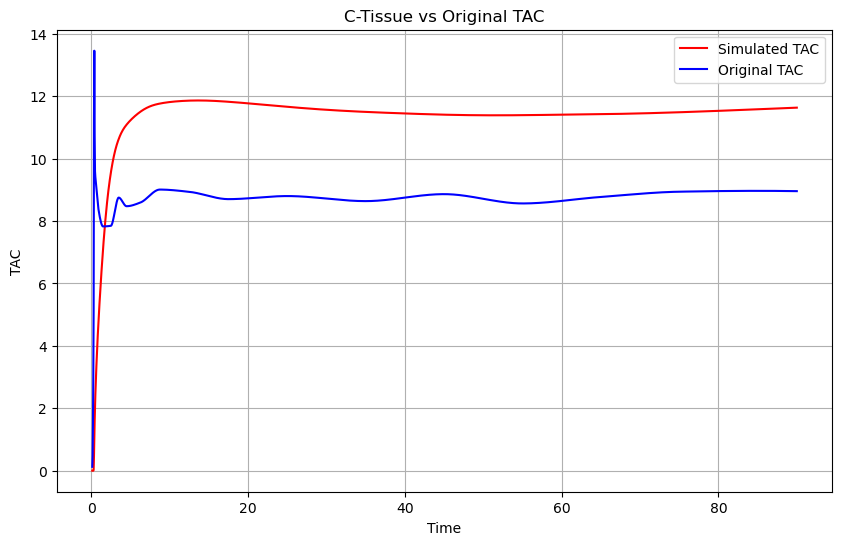

In [25]:
dt = new_rtim[1] - new_rtim[0]
simulated_c_tissue_values = c_tissue_torch(IRF_values, pchip_pl, dt)

# Plot the simulated C_Tissue values against the original TAC values
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_c_tissue_values, label='Simulated TAC', color='red')
plt.plot(new_rtim, pchip_tac, label='Original TAC', color='blue')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('C-Tissue vs Original TAC')
plt.legend()
plt.grid(True)
plt.show()

<h3> Scipy <h3>

In [24]:
import scipy.signal

def c_tissue5(IRF_values, pchip_pl, dt):
    """
    Calculates the simulated C_Tissue values for the given IRF and plasma concentration values.

    Parameters:
    IRF_values (list): The IRF values.
    pchip_pl (list): Plasma concentration values interpolated using PCHIP.
    dt (float): The time step increment.

    Returns:
    list: The simulated C_Tissue values.
    """
    num_points = len(IRF_values) 

    # Compute the convolution of the two lists
    simulated_c_tissue_values = scipy.signal.convolve(IRF_values, pchip_pl, mode='full')[:num_points]

    # Normalize the convolution result
    normalized_c_tissue = simulated_c_tissue_values * dt # Multiply by dt

    return normalized_c_tissue


In [25]:
dt = new_rtim[1] - new_rtim[0]
simulated_c_tissue_values = c_tissue5(IRF_values, pchip_pl, dt)

print("pl_chip:", len(pchip_pl))
print("IRF:", len(IRF_values))

#print(simulated_c_tissue_values)
print(len(simulated_c_tissue_values))

pl_chip: 2048
IRF: 2048
2048


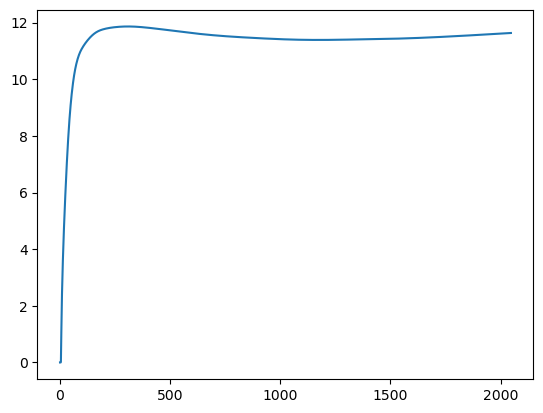

In [26]:
#Divide simulated tac values by constant
#simulated_c_tissue_values = [x / 1.238 for x in simulated_c_tissue_values]

plt.plot(simulated_c_tissue_values)
plt.show()

<h2>Simulated TAC <h2>

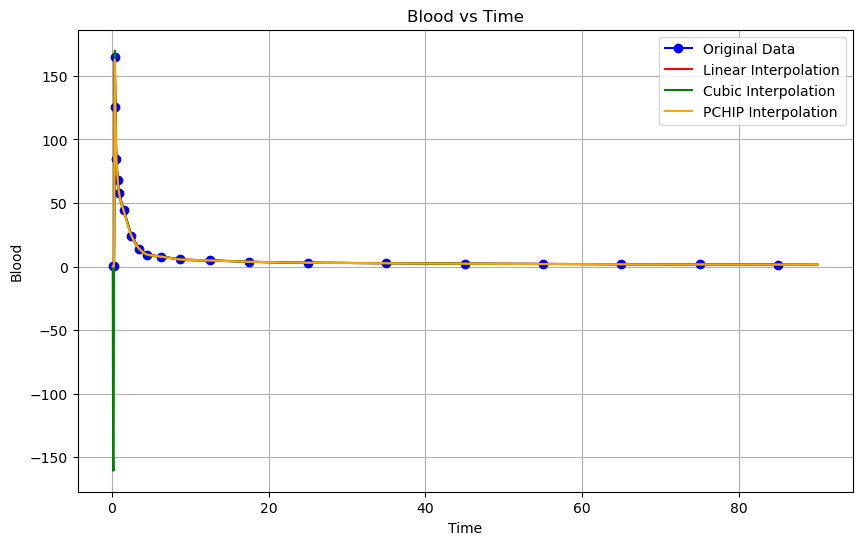

In [22]:
# Get the interpolated blood values
new_rtim, linear_bl, cubic_bl, pchip_bl = equidistant_interpolation(data_from_first_row['rtim_list'],
                                                          data_from_first_row['bl_list'],
                                                          num_equidistant_points)

plot_interpolations(data_from_first_row['rtim_list'], 
                    data_from_first_row['bl_list'], 
                    new_rtim, linear_bl, cubic_bl, pchip_bl, 'Blood')

In [23]:
def simulated_tac(c_tissue, gt_parameters_list, bl_list):
    """
    Calculates the simulated TAC values for the given C_Tissue and blood concentration values.

    Parameters:
    c_tissue (list): The C_Tissue values.
    gt_parameters_list (list): The ground truth parameters.
    bl_list (list): Blood concentration values.

    Returns:
    list: The simulated TAC values.
    """
    simulated_tac_values = []
    vb = gt_parameters_list[3]

    for i in range(len(c_tissue)):
        value = c_tissue[i] * (1-vb) + vb * bl_list[i]
        simulated_tac_values.append(value)
    
    return simulated_tac_values
    

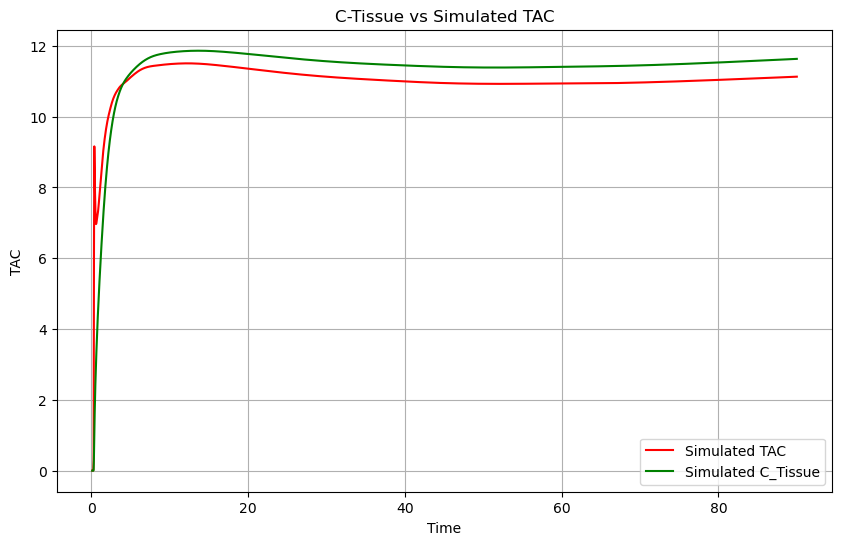

In [24]:
simulated_tac_values = simulated_tac(simulated_c_tissue_values, data_from_first_row['gt_parameters_list'], pchip_bl)

# Plot the simulated C_Tissue values against the original TAC values
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='red')
plt.plot(new_rtim, simulated_c_tissue_values, label='Simulated C_Tissue', color='green')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('C-Tissue vs Simulated TAC')
plt.legend()
plt.grid(True)
plt.show()

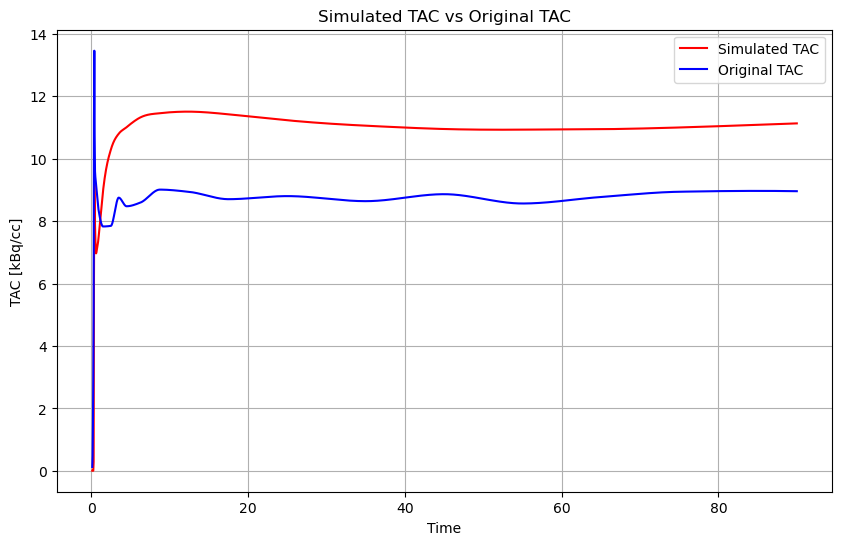

In [25]:
# Plot the simulated TAC values against the original TAC values
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='red')
plt.plot(new_rtim, pchip_tac, label='Original TAC', color='blue')
plt.xlabel('Time')
plt.ylabel('TAC [kBq/cc]')
plt.title('Simulated TAC vs Original TAC')
plt.legend()
plt.grid(True)
plt.show()

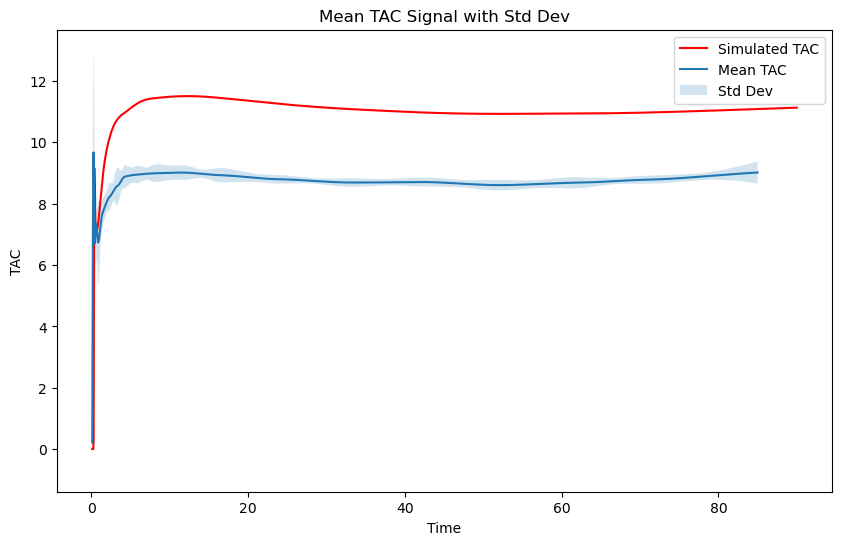

In [26]:
# Initialize lists to store interpolated TAC signals
all_linear_tac = []

# Iterate over the first 25 rows of the DataFrame
for i in range(25):
    data_from_row = DataLoader(i, df)  # Adjust this if DataLoader usage is different
    # Apply equidistant interpolation to each row
    _, _, _, pchip_tac = equidistant_interpolation(data_from_row['rtim_list'],
                                                    data_from_row['tac_list'],
                                                    num_equidistant_points)
    # Append the interpolated signal to the list
    all_linear_tac.append(pchip_tac)

# Convert the list of arrays into a 2D numpy array for easier manipulation
all_linear_tac = np.array(all_linear_tac)

# Calculate the mean and standard deviation across the 25 signals
mean_tac = np.mean(all_linear_tac, axis=0)
std_tac = np.std(all_linear_tac, axis=0)

# Create the time points for plotting, assuming equidistant spacing
time_points = np.linspace(min(data_from_row['rtim_list']), max(data_from_row['rtim_list']), num_equidistant_points)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='red')
plt.plot(time_points, mean_tac, label='Mean TAC')
plt.fill_between(time_points, mean_tac-std_tac, mean_tac+std_tac, alpha=0.2, label='Std Dev')
plt.title('Mean TAC Signal with Std Dev')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.legend()
plt.show()


<h2> Noise <h2>

In [27]:
def adding_noise_simple(simulated_tac_values, new_rtim, original_time, COVi=None):
    """
    Adds normal noise to the simulated TAC values.

    Parameters:
    simulated_tac_values (list): The simulated TAC values.
    new_rtim (list): The new resampled time points.
    original_time (list): The original time points.
    COVi (float): The COVi value.

    Returns:
    list: The noisy TAC values.
    list: The added noise.
    float: The approximate COVi value.
    """
    # Convert inputs to numpy arrays for efficient computation
    simulated_tac_values = np.array(simulated_tac_values)
    new_rtim = np.array(new_rtim)
    original_time = np.array(original_time)

    # Get the indices of the closest points in original time to the new resampled time points
    closest_indices = [np.argmin(np.abs(new_rtim - t)) for t in original_time]
    
    # Select the corresponding TAC values based on the closest indices
    tac_values_at_closest_indices = simulated_tac_values[closest_indices]

    # Get the last three TAC values
    last_three_tac = tac_values_at_closest_indices[-3:]

    # Calculate the standard deviation using the last three TAC values
    std_dev = np.std(last_three_tac)

    # Calculate the mean of the last three TAC values
    mean = np.mean(last_three_tac)

    # Calculate approximate COVi:
    approx_COVi = std_dev / mean
    
    # Calculate the noise
    if COVi is not None: # If COVi is provided, use it to calculate the noise
        noise = np.random.normal(0, COVi * mean, len(simulated_tac_values))
    else: # If COVi is not provided, use the standard deviation to calculate the noise
        noise = np.random.normal(0, std_dev, len(simulated_tac_values))
        
    # Add the noise to the simulated TAC values
    noisy_tac = simulated_tac_values + noise

    return noisy_tac, noise, approx_COVi

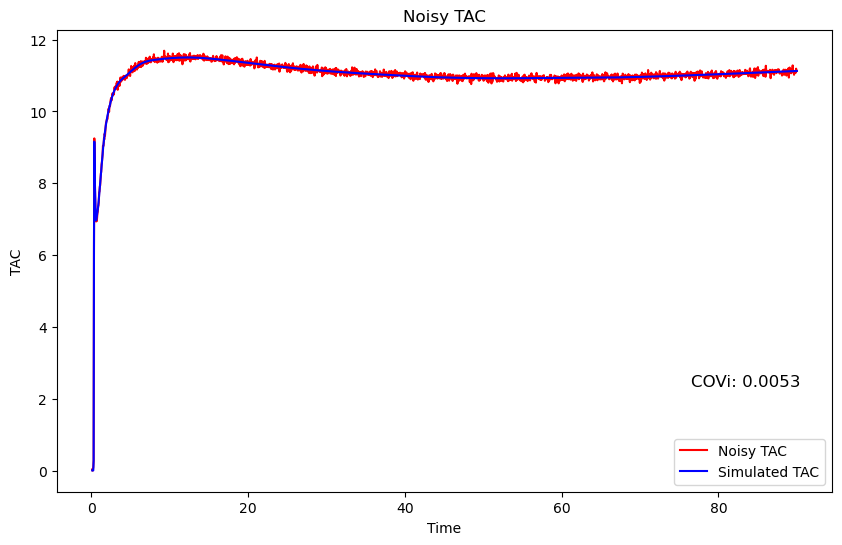

In [28]:
noisy_tac, noise, COVi = adding_noise_simple(simulated_tac_values, new_rtim, data_from_row['rtim_list'])

# Plot the noisy TAC values
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, noisy_tac, label='Noisy TAC', color='red')
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='blue')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('Noisy TAC')
plt.text(x=max(new_rtim) * 0.85, y=max(noisy_tac) * 0.2, s=f'COVi: {COVi:.4f}', fontsize=12, color='black')
plt.legend()
plt.show()

In [29]:
def adding_noise_advanced(simulated_tac_values, new_rtim, type='Normal'):
    """
    Adds noise to the simulated TAC values in a more advanced way. The variance of the noise is calculated for each tac window.

    Parameters:
    simulated_tac_values (list): The simulated TAC values.
    new_rtim (list): The new time points.
    type (str): The type of noise to add. Either 'Poisson' or 'Normal'.

    Returns:
    list: The simulated TAC values with added noise.
    list: The added noise.
    """
    # List of original time points
    times = [0.125, 0.291667, 0.375, 0.458333, 0.583333, 0.75, 0.916667, 1.5, 2.5, 3.5, 4.5, 6.25, 8.75, 12.5, 17.5, 25, 35, 45, 55, 65, 75, 85]
    lengths = [0.166667, 0.083333, 0.083333, 0.125, 0.166667, 0.166667, 0.583333, 1, 1, 1, 1.75, 1.5, 3.75, 5, 7.5, 10, 10, 10, 10, 10, 10, 10]

    # Find new_rtim values that are closest to the original time points
    closest_indices = [np.argmin(np.abs(new_rtim - t)) for t in times]

    # Calculate the mean and standard deviation of the TAC values in each window
    tac_mean_values = []
    tac_std_dev_values = []
    for i in range(len(times)):
        if i == len(times) - 1:
            # Last interval
            interval_tac = simulated_tac_values[closest_indices[i]:]
        else:
            interval_tac = simulated_tac_values[closest_indices[i]:closest_indices[i+1]]
        tac_mean_values.append(np.mean(interval_tac))
        tac_std_dev_values.append(np.std(interval_tac))
    
    # Add noise to each window
    noisy_tac = []
    noise = []
    for i in range(len(times)):
        # Determine start index
        start_index = closest_indices[i]
        
        # Determine end index: If it's the last element, slice to the end of the array. Otherwise, use the next closest index.
        if i == len(times) - 1:
            end_index = None 
        else:
            end_index = closest_indices[i + 1]
        
        # Slicing tac_window and corresponding new_rtim values
        tac_window = simulated_tac_values[start_index:end_index]
        rtim_window = new_rtim[start_index:end_index]
        
        # Calculate the decay correction factor
        decay = np.log(2) / 109.8 # Fluorine-18 half-life is 109.8 minutes
        F_decay = 1 * np.exp(-decay * rtim_window)
        dcfi = np.trapz(F_decay, rtim_window) / lengths[i]

        # Calculate Ti
        Ti = tac_mean_values[i] * lengths[i] / dcfi

        # Calculate the local variance
        local_variance = (dcfi**2 / (lengths[i]**2)) * Ti
        
        # Generate the noise
        if type == 'Poisson':
            #local_noise = np.random.poisson(0.02 * tac_mean_values[i], size=len(tac_window))
            local_noise = np.random.poisson(np.sqrt(local_variance), size=len(tac_window))
        elif type == 'Normal':
            #local_noise = np.random.normal(0, 0.02 * tac_mean_values[i], size= len(tac_window))
            local_noise = np.random.normal(0, np.sqrt(local_variance), size=len(tac_window))
        
        noise += local_noise.tolist()

    # Add the noise to the simulated TAC values
    simulated_tac_values = np.array(simulated_tac_values)
    noise = np.array(noise)
    noisy_tac = simulated_tac_values + noise
        
    return noisy_tac, noise

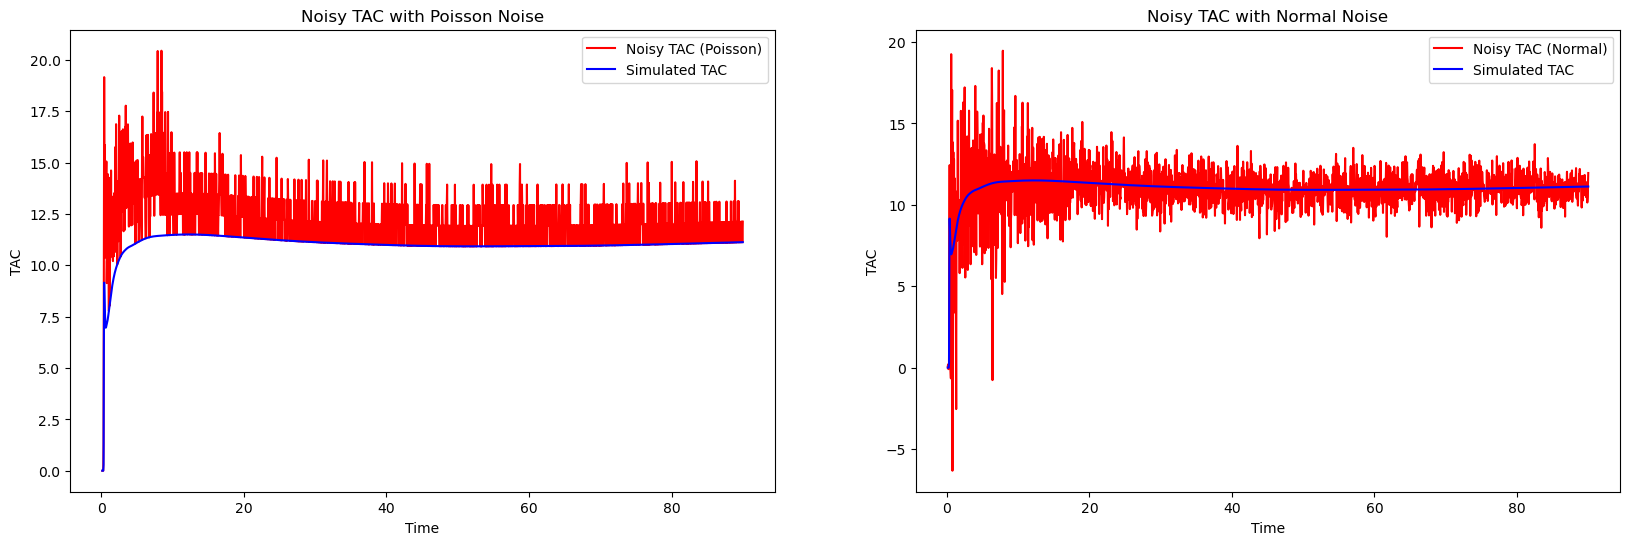

In [30]:
# First, generate noisy TAC values with Poisson noise
noisy_tac_poisson, noise_poisson = adding_noise_advanced(simulated_tac_values, new_rtim, 'Poisson')

# Then, generate noisy TAC values with Normal noise
noisy_tac_normal, noise_normal = adding_noise_advanced(simulated_tac_values, new_rtim, 'Normal')

# Plot both noisy TAC values side by side
plt.figure(figsize=(20, 6))  # Adjust the figure size as needed

# Plot for Poisson noise
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(new_rtim, noisy_tac_poisson, label='Noisy TAC (Poisson)', color='red')
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='blue')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('Noisy TAC with Poisson Noise')
plt.legend()

# Plot for Normal noise
plt.subplot(1, 2, 2)  # (rows, columns, panel number)
plt.plot(new_rtim, noisy_tac_normal, label='Noisy TAC (Normal)', color='red')
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='blue')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('Noisy TAC with Normal Noise')
plt.legend()

plt.show()


<h3>  Generate signal <h3>

In [31]:
def generate_tac(data_row, num_points, type='Simple', COVi=None):
    """
    Generates the TAC signal for the given data row.

    Parameters:
    data_row (pd.Series): The data row containing the required information.
    num_points (int): The number of points to generate.
    type (str): The type of noise to add. Either 'Simple' or 'Advanced'.
    COVi (float): The COVi value.

    Returns:
    list: The new time points.
    list: The simulated TAC values.
    list: The generated TAC signal.
    """
    # Interpolate the required signals using PCHIP
    new_rtim, _, _, pchip_pl = equidistant_interpolation(data_row['rtim_list'], data_row['pl_list'], num_points)
    _, _, _, pchip_bl = equidistant_interpolation(data_row['rtim_list'], data_row['tac_list'], num_points)

    # Calculate the IRF values
    IRF_values = IRF(data_row['gt_parameters_list'], new_rtim)

    # Calculate the C_Tissue values
    dt = new_rtim[1] - new_rtim[0]
    simulated_c_tissue_values = c_tissue5(IRF_values, pchip_pl, dt)

    # Calculate the simulated TAC values
    simulated_tac_values = simulated_tac(simulated_c_tissue_values, data_row['gt_parameters_list'], pchip_bl)

    # Add noise to the simulated TAC values
    if type == 'Simple': # Use the simple noise addition method
        noisy_tac, _, _ = adding_noise_simple(simulated_tac_values, new_rtim, data_row['rtim_list'], COVi)
    elif type == 'Advanced': # Use the advanced noise addition method
        noisy_tac, _ = adding_noise_advanced(simulated_tac_values, new_rtim, 'Normal')

    return new_rtim, simulated_tac_values, noisy_tac

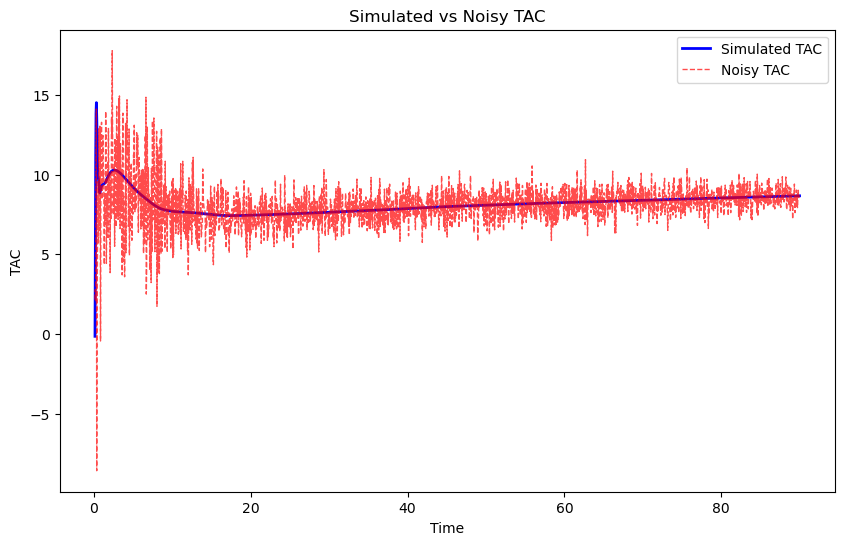

In [32]:
# Generate the TAC signal for the first row
data_row = DataLoader(96540, df)
new_rtim, simulated_tac_values, noisy_tac = generate_tac(data_row, num_equidistant_points, type='Advanced')

# Plot the simulated and noisy TAC signals
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='blue', linewidth=2)
plt.plot(new_rtim, noisy_tac, label='Noisy TAC', color='red', linestyle='--', linewidth=1, alpha=0.7)
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('Simulated vs Noisy TAC')
plt.legend()
plt.show()


<h3>Save signals <h3>

In [33]:
noisy_tacs = []
gt_parameters = []
generation = False

if generation == True:
    # Save signals to a npz file
    num_equidistant_points = 2048
    for i in range(0, df.index[-1], 25):
        data_row = DataLoader(i, df)
        _, _, noisy_tac = generate_tac(data_row, num_equidistant_points)

        # Append the noisy TAC and ground truth parameters to the lists
        noisy_tacs.append(noisy_tac)
        data_row['gt_parameters_list'].extend([0])  # Append an extra zero for k4
        gt_parameters.append(data_row['gt_parameters_list'])

        # Print the progress
        if i % 10000 == 0 and i != 0:
            print(i)
            print(data_row['gt_parameters_list'])
        
        if i == 2500:
            break

    # Convert the lists to numpy arrays
    noisy_tacs = np.array(noisy_tacs)
    gt_parameters = np.array(gt_parameters)

    print(noisy_tacs.shape)
    print(gt_parameters.shape)

    # Save the arrays to a .npz file
    np.savez('internal_data.npz', noisy_tacs=noisy_tacs, gt_parameters=gt_parameters)
    

<h2> Deep Learning <h2>

<h3>Multiple models<h3>

In [1]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import numpy as np
import torch
import torch.nn.init as init
import torch.nn.functional as F
import matplotlib.pyplot as plt
from source.Data_generation import IRF, equidistant_interpolation, c_tissue, simulated_tac
from source.Plots import *

In [19]:
def IRF_torch(gt_parameters_tensor, equidistant_rtim_tensor):
    """
    Calculates the impulse response function (IRF) for the given parameters and equidistant timepoints using PyTorch.

    Parameters:
    gt_parameters_tensor (torch.Tensor): Tensor of parameters.
    equidistant_rtim_tensor (torch.Tensor): Tensor of equidistant timepoints.

    Returns:
    torch.Tensor: The IRF values.
    """
    # Given that gt_parameters_tensor shape is [batch_size, 4]
    k1, k2, k3 = gt_parameters_tensor[:, 0], gt_parameters_tensor[:, 1], gt_parameters_tensor[:, 2]
    k4 = torch.zeros_like(k1)  # Ensuring k4 is the same shape and device as k1

    # Calculate alphas for the entire batch
    sqrt_term = torch.sqrt(torch.clamp((k2 + k3 + k4)**2 - 4*k2*k4, min=0))
    alpha1 = (k2 + k3 + k4) - sqrt_term / 2.0
    alpha2 = (k2 + k3 + k4) + sqrt_term / 2.0

    # Calculate IRF for each time point and each batch
    epsilon = 1e-8
    equidistant_rtim_tensor = equidistant_rtim_tensor.unsqueeze(0)  # Adding a batch dimension for broadcasting
    value = ((k3 + k4 - alpha1).unsqueeze(1) * torch.exp(-alpha1.unsqueeze(1) * equidistant_rtim_tensor) + 
             (alpha2 - k3 - k4).unsqueeze(1) * torch.exp(-alpha2.unsqueeze(1) * equidistant_rtim_tensor)) / (alpha2 - alpha1 + epsilon).unsqueeze(1)
    
    IRF = value * k1.unsqueeze(1)  # Ensuring k1 is correctly broadcasted over the time dimension

    return IRF


def c_tissue_torch(IRF_tensor, pchip_tensor, dt):
    """
    Calculates the simulated C_Tissue values for the given IRF and plasma concentration values using PyTorch.
    This version ensures that inputs and kernels are properly shaped for PyTorch's conv1d.

    Parameters:
    IRF_tensor (torch.Tensor): The IRF values as a tensor.
    pchip_tensor (torch.Tensor): Plasma concentration values as a tensor, interpolated using PCHIP or equivalent.
    dt (float): The time step increment.

    Returns:
    torch.Tensor: The simulated C_Tissue values as a tensor.
    """
    # Ensure tensors have the correct shape (Batch, Channel, Length)
    if IRF_tensor.dim() == 1:
        IRF_tensor = IRF_tensor.unsqueeze(0).unsqueeze(0)
    elif IRF_tensor.dim() == 2:
        IRF_tensor = IRF_tensor.unsqueeze(1)

    if pchip_tensor.dim() == 1:
        pchip_tensor = pchip_tensor.unsqueeze(0).unsqueeze(0)
    elif pchip_tensor.dim() == 2:
        pchip_tensor = pchip_tensor.unsqueeze(1)

    # Perform 1D convolution. Flip the IRF tensor because PyTorch's conv1d performs cross-correlation.
    padding_size = (IRF_tensor.size(-1) - 1)
    simulated_c_tissue_values = F.conv1d(pchip_tensor, IRF_tensor.flip(dims=[-1]), padding=padding_size)[:,:,:pchip_tensor.size(-1)]

    # Normalize the convolution result by multiplying by dt
    normalized_result_tensor = simulated_c_tissue_values * dt

    # Remove unnecessary batch and channel dimensions before returning
    return normalized_result_tensor.squeeze()


def simulated_tac_torch(c_tissue, gt_parameters, bl_tensor):
    """
    Calculates the simulated TAC values for the given C_Tissue and blood concentration values using PyTorch.

    Parameters:
    c_tissue (torch.Tensor): The C_Tissue values with shape [batch_size, num_points].
    gt_parameters (torch.Tensor): The ground truth parameters with shape [batch_size, num_params].
    bl_tensor (torch.Tensor): Blood concentration values with shape [num_points].

    Returns:
    torch.Tensor: The simulated TAC values with shape [batch_size, num_points].
    """
    # Extracting the 'vb' parameter from the ground truth parameters, assuming it is the fourth parameter
    # The shape of vb is [batch_size, 1] after unsqueezing
    vb = gt_parameters[:, 3].unsqueeze(1)

    # Broadcasting 'vb' and 'bl_tensor' across the batch size and num_points, respectively, for efficient computation
    simulated_tac_values = c_tissue * (1 - vb) + vb * bl_tensor

    return simulated_tac_values


def TAC_loss(predicted_param, inputs, num_equidistant_points = 2048):
    """
    Calculate the loss between the true and predicted TAC values.

    Parameters:
    true_param (torch.Tensor): True parameter values
    predicted_param (torch.Tensor): Predicted parameter values
    num_equidistant_points (int): Number of equidistant points to interpolate the plasma and blood concentration values

    Returns:
    torch.Tensor: Mean squared error between the true and predicted TAC values
    """
    # Fixed data values
    rtim_list = [0.125, 0.291667, 0.375, 0.458333, 0.583333, 0.75, 0.916667, 1.5, 2.5, 3.5, 4.5, 6.25, 8.75, 12.5, 
                 17.5, 25, 35, 45, 55, 65, 75, 85]
    pl_list = [0.05901, 0.0550587, 110.023, 83.0705, 55.6943, 44.4686, 36.9873, 27.5891, 13.5464, 6.33916, 3.52664, 
               2.49758, 1.44494, 1.04103, 0.71615, 0.52742, 0.43791, 0.35239, 0.32866, 0.27326, 0.26068, 0.24129]
    bl_list = [0.08737, 0.081723, 164.763, 125.181, 84.5654, 68.4428, 58.1711, 44.4919, 24.3138, 14.0272, 9.47834, 
               7.88443, 5.59859, 4.81384, 3.79608, 3.04436, 2.67881, 2.23747, 2.13455, 1.80559, 1.74821, 1.63998]

    # Interpolate plasma and blood concentration values
    new_rtim, _, _, pchip_pl = equidistant_interpolation(rtim_list, pl_list, num_equidistant_points)
    _, _, _, pchip_bl = equidistant_interpolation(rtim_list, bl_list, num_equidistant_points)

    # Convert the interpolated plasma and blood concentration values to PyTorch tensors
    pchip_pl_tensor = torch.tensor(pchip_pl, dtype=torch.float32)
    pchip_bl_tensor = torch.tensor(pchip_bl, dtype=torch.float32)
    new_rtim_tensor = torch.tensor(new_rtim, dtype=torch.float32)
    
    # Calculate the impulse response functions:
    pred_irf = IRF_torch(predicted_param, new_rtim_tensor)

    # Calculate the C-Tissue values
    dt = new_rtim[1] - new_rtim[0]
    pred_c_tissue = c_tissue_torch(pred_irf, pchip_pl_tensor, dt)

    # # prints
    # print("pred_c_tissue:", pred_c_tissue.shape)
    # print("pred para:", predicted_param.shape)
    # print("inputs:", inputs.shape)

    # Calculate the simulated TAC values
    pred_tac = simulated_tac_torch(pred_c_tissue, predicted_param, pchip_bl_tensor)

    # # Plot one of the tac values for verification
    # plt.plot(pred_tac[0].detach().numpy())
    # plt.show()

    return nn.MSELoss()(inputs, pred_tac)

In [2]:
def ki_macro(k1, k2, k3):
    """
    Computes the macro parameter k_i from the parameters k1, k2, and k3.

    Parameters:
    k1 (float): The first parameter.
    k2 (float): The second parameter.
    k3 (float): The third parameter.

    Returns:
    float: The macro rate constant k_i.
    """
    ki = (k1 * k2) / (k2 + k3)
    return ki

In [15]:
def training_single_model(config):
    """
    Trains a single model to predict all four parameters.

    Parameters:
    config (dict): A dictionary containing the configuration values for training the model.
    data (dict): The data dictionary containing the noisy TAC signals and ground truth parameters.
    model_class (nn.Module): The neural network model to train.
    loss_function (nn.Module): The loss function to use.
    batch_size (int): The batch size for training.
    lr (float): The learning rate for the optimizer.
    patience (int): The patience for early stopping.
    epochs (int): The maximum number of epochs to train.
    progress (bool): Whether to print the validation loss at each epoch.
    TAC_loss (bool): Whether to use the TAC loss or traditional loss.

    Returns:
    nn.Module: The trained model.
    dict: A dictionary containing the best validation loss, mean percentage difference, and standard deviation of the percentage difference.
    """
    # Extracting configuration values
    data = config['data']
    model_class = config['model_class']
    loss_function = config['loss_function']
    batch_size = config.get('batch_size', 1024)
    lr = config.get('lr', 0.001)
    patience = config.get('patience', 5)
    epochs = config.get('epochs', 50)
    progress = config.get('progress', False)
    TAC_loss = config.get('TAC_loss', False)  # Whether to use the TAC loss or traditional loss

    # Extract the data from the data dictionary
    inputs = data["noisy_tacs"]
    true_params = data["gt_parameters"]

    # Convert the arrays to PyTorch tensors
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32).to(device)
    true_params_tensor = torch.tensor(true_params[:, :-1], dtype=torch.float32).to(device) # Remove the last column (k4)

    # Split data into training and validation sets
    total_samples = inputs_tensor.shape[0]
    train_size = int(0.8 * total_samples)
    val_size = total_samples - train_size

    # Create a TensorDataset and DataLoader
    dataset = TensorDataset(inputs_tensor, true_params_tensor)

    # Randomly split dataset into training and validation datasets
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create DataLoaders for both training and validation sets
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model
    in_features = inputs_tensor.shape[1]
    model = model_class(in_features, device).to(device)

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Early stopping
    best_val_loss = np.inf  # Initialize the best validation loss as infinity
    patience_counter = 0  # Counter for epochs waited
    
    for epoch in range(epochs):
        model.train()  # Set the model to training mode

        for inputs, true_params in train_dataloader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            predicted_params = model(inputs)

            # Compute the loss
            if TAC_loss: 
                loss = loss_function(predicted_params, inputs) 
            else:
                loss = loss_function(predicted_params, true_params)

            # Backward pass
            loss.backward()

            # Update the weights
            optimizer.step()
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, true_params in val_dataloader:
                predicted_params = model(inputs)
                if TAC_loss:
                    loss = loss_function(predicted_params, inputs)
                else:
                    loss = loss_function(predicted_params, true_params)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_dataloader)
        if progress == True:
            print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss}")

        # Early stopping logic
        if avg_val_loss < best_val_loss:  # Check for improvement with a minimum delta
            best_val_loss = avg_val_loss  # Update the best validation loss
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1  # Increase patience counter
        
        if patience_counter >= patience:  # Check if patience counter has reached the patience limit
            if progress == True:
                print(f"Stopping early at epoch {epoch + 1}")
            break

    # Final evaluation on the validation set
    true_params_list = []
    predicted_params_list = []

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for inputs, true_params in val_dataloader:
            predicted_params = model(inputs)
            if TAC_loss:
                loss = loss_function(predicted_params, inputs)
            else:
                loss = loss_function(predicted_params, true_params)
            total_val_loss += loss.item()
            true_params_list.append(true_params.cpu().numpy())
            predicted_params_list.append(predicted_params.cpu().numpy())

    # Concatenate all batches to get the whole validation set predictions
    true_params_concat = np.concatenate(true_params_list, axis=0)
    predicted_params_concat = np.concatenate(predicted_params_list, axis=0)

    # Compute k_i for the true and predicted parameters
    true_ki = ki_macro(true_params_concat[:, 0], true_params_concat[:, 1], true_params_concat[:, 2])
    predicted_ki = ki_macro(predicted_params_concat[:, 0], predicted_params_concat[:, 1], predicted_params_concat[:, 2])

    # Append k_i as a new column to the true and predicted params
    true_params_concat = np.column_stack((true_params_concat, true_ki))
    predicted_params_concat = np.column_stack((predicted_params_concat, predicted_ki))

    # Create dictionary with all the results
    results = {
        "true_params": true_params_concat,
        "predicted_params": predicted_params_concat
    }
    
    return model, results

In [8]:
# Device selection logic
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():  # Check for MPS availability (Apple Silicon)
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [10]:
class FC_single_bounded(nn.Module):
    def __init__(self, in_features, device, dropout_rate=0.1):
        super(FC_single_bounded, self).__init__()
        self.device = device  # Add this line to store device
        self.fc1 = nn.Linear(in_features, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        x = self.dropout1(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(torch.relu(self.bn2(self.fc2(x))))
        x = torch.sigmoid(self.fc3(x))
        
        a = torch.tensor([0.28, 0.15, 0.7, 0.35]).to(self.device)
        b = torch.tensor([0.13, 0.014, 0.025, 0.05]).to(self.device)
        x = a * x + b

        return x


In [11]:
#loss = nn.MSELoss()
loss = nn.L1Loss()
#loss = TAC_loss

config = { 
    'data': np.load("data/Generated_Data/simulation_simple_0.01.npz"),
    'model_class': FC_single_bounded,
    'loss_function': loss,
    'batch_size': 1024,
    'lr': 0.0001,
    'patience': 5,
    'epochs': 50,
    'progress': True,
    'TAC_loss': False,
    'n_models': 5
}

In [16]:
# Set the random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

results_list = []
n_models = config['n_models']
for i in range(n_models):
    print(f"Training model {i + 1}")
    model, results = training_single_model(config)
    # Append the results
    results_list.append(results)    

Training model 1
Epoch 1, Validation Loss: 0.08828583359718323
Epoch 2, Validation Loss: 0.06854897178709507
Epoch 3, Validation Loss: 0.06412205100059509
Epoch 4, Validation Loss: 0.05174407362937927
Epoch 5, Validation Loss: 0.05784462485462427
Epoch 6, Validation Loss: 0.05204595346003771
Epoch 7, Validation Loss: 0.045799738727509975
Epoch 8, Validation Loss: 0.04901776369661093
Epoch 9, Validation Loss: 0.040344313718378544
Epoch 10, Validation Loss: 0.04689192399382591
Epoch 11, Validation Loss: 0.04053316172212362
Epoch 12, Validation Loss: 0.04546122066676617
Epoch 13, Validation Loss: 0.04976711142808199
Epoch 14, Validation Loss: 0.042151305824518204
Stopping early at epoch 14
Training model 2
Epoch 1, Validation Loss: 0.09627887420356274
Epoch 2, Validation Loss: 0.07234232127666473
Epoch 3, Validation Loss: 0.059481711126863956
Epoch 4, Validation Loss: 0.056031372398138046
Epoch 5, Validation Loss: 0.055616104044020176
Epoch 6, Validation Loss: 0.05022620689123869
Epoch 7,

Parallel network

In [20]:
class FC_parallel_bounded(nn.Module):
    def __init__(self, in_features, dropout_rate=0.1):
        super(FC_parallel_bounded, self).__init__()
        self.fc1 = nn.Linear(in_features, 256)  # Adjust in_features to match your data
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(dropout_rate)  # Dropout layer after the first activation
        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout_rate)  # Dropout layer after the second activation
        self.fc3 = nn.Linear(64, 1)  # Output layer

    def forward(self, x):
        x = self.dropout1(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(torch.relu(self.bn2(self.fc2(x))))
        x = torch.sigmoid(self.fc3(x))

        x = 0.711 * x + 0.014  # Scale the output to [0.014, 0.725]

        return x

In [27]:
def training_parallel_models(config):
    """
    Trains a group of models parallelly for each parameter.

    Parameters:
    config (dict): The configuration dictionary containing the training parameters.
    data (dict): The data dictionary containing the noisy TAC signals and ground truth parameters.
    model_class (nn.Module): The neural network model to train.
    loss_function (nn.Module): The loss function to use.
    batch_size (int): The batch size for training.
    lr (float): The learning rate for the optimizer.
    patience (int): The patience for early stopping.
    epochs (int): The maximum number of epochs to train.
    progress (bool): Whether to print the validation loss at each epoch.

    Returns:
    nn.Module: The trained model.
    dict: A dictionary containing the best validation loss, mean percentage difference, and standard deviation of the percentage difference.
    """
    # Unpack the configuration dictionary
    data = config['data']
    model_class = config['model_class']
    loss_function = config['loss_function']
    batch_size = config.get('batch_size', 1024)
    lr = config.get('lr', 0.001)
    patience = config.get('patience', 5)
    epochs = config.get('epochs', 50)
    progress = config.get('progress', False)
    TAC_loss = config.get('TAC_loss', False)  # Whether to use the TAC loss or traditional loss

    # Extract the data from the dictionary
    inputs = data["noisy_tacs"]
    true_params = data["gt_parameters"]

    # Convert the arrays to PyTorch tensors
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32).to(device)
    true_params_tensor = torch.tensor(true_params[:, :-1], dtype=torch.float32).to(device) # Remove the last column (k4)

    # Split data into training and validation sets
    total_samples = inputs_tensor.shape[0]
    train_size = int(0.8 * total_samples)
    val_size = total_samples - train_size

    # Create a TensorDataset and DataLoader
    dataset = TensorDataset(inputs_tensor, true_params_tensor)

    # Randomly split dataset into training and validation datasets
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create DataLoaders for both training and validation sets
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the models for each parameter
    models = [model_class(in_features=inputs_tensor.shape[1]).to(device) for _ in range(4)]

    # Optimizers (one for each model)
    optimizers = [optim.Adam(model.parameters(), lr=lr) for model in models]

    # Early stopping
    best_val_loss = np.inf  # Initialize the best validation loss as infinity
    patience_counter = 0  # Counter for epochs waited

    # Training loop
    for epoch in range(epochs):
        # Set models to training mode
        for model in models:
            model.train()
            
        # Iterate over training data
        for inputs, true_params in train_dataloader:
            current_predictions = []
            
            # Collect predictions from all models without computing the loss yet
            for i, model in enumerate(models):
                predicted_param = model(inputs).squeeze()
                current_predictions.append(predicted_param.unsqueeze(1))  # Make it a column vector
                
            # Concatenate predictions along dimension 1 to form a [batch_size, 4] tensor
            all_predictions = torch.cat(current_predictions, dim=1)
            
            # Compute the loss
            if TAC_loss:
                # Note: Assuming the TAC loss function is designed to take all predictions and inputs
                loss = loss_function(all_predictions, inputs)
            else:
                # This branch may not be used, but included for completeness
                loss = loss_function(all_predictions, true_params)
            
            # Backward pass and optimization
            for optimizer in optimizers:
                optimizer.zero_grad()
            
            loss.backward()
            
            for optimizer in optimizers:
                optimizer.step()

            
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, true_params in val_dataloader:
                predicted_params_list = []

                for i, model in enumerate(models):
                    # Forward pass
                    predicted_param = model(inputs).squeeze()
                    predicted_params_list.append(predicted_param.unsqueeze(1))
                
                # Concatenate the predictions along dimension 1
                predicted_params = torch.cat(predicted_params_list, dim=1)

                # Compute loss 
                if TAC_loss:
                    loss = loss_function(predicted_params, inputs)
                else:
                    loss = loss_function(predicted_param, true_params)

                # Accumulate the loss
                total_val_loss += loss.item()
                
        avg_val_loss = total_val_loss / len(val_dataloader)
        if progress == True:
            print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss}")
        
        # Early stopping logic
        if avg_val_loss < best_val_loss:  # Check for improvement with a minimum delta
            best_val_loss = avg_val_loss  # Update the best validation loss
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1  # Increase patience counter
        
        if patience_counter >= patience:  # Check if patience counter has reached the patience limit
            if progress == True:
                print(f"Stopping early at epoch {epoch + 1}")
            break
    
    # Final evaluation on the validation set
    # Initialize lists to accumulate the true and predicted parameters
    accumulated_true_params = []
    accumulated_predicted_params = []

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for inputs, true_params in val_dataloader:
            predicted_eval_params_list = []

            for i, model in enumerate(models):
                # Forward pass
                predicted_param = model(inputs).squeeze()
                predicted_eval_params_list.append(predicted_param.unsqueeze(1))
            
            # Concatenate the predictions along dimension 1
            predicted_eval_params = torch.cat(predicted_eval_params_list, dim=1)

            # Compute the loss
            if TAC_loss:
                loss = loss_function(predicted_eval_params, inputs)
            else:
                loss = loss_function(predicted_param, true_params)

            # Accumulate the loss
            total_val_loss += loss.item()

            # Accumulate the true and predicted parameters for later analysis
            accumulated_true_params.append(true_params.cpu().numpy())
            accumulated_predicted_params.append(predicted_eval_params.cpu().numpy())
    
    # After accumulating results from all batches, concatenate them
    true_params_concat = np.concatenate(accumulated_true_params, axis=0)
    predicted_params_concat = np.concatenate(accumulated_predicted_params, axis=0)

    # Compute k_i for the true and predicted parameters
    true_ki = ki_macro(true_params_concat[:, 0], true_params_concat[:, 1], true_params_concat[:, 2])
    predicted_ki = ki_macro(predicted_params_concat[:, 0], predicted_params_concat[:, 1], predicted_params_concat[:, 2])

    # Append k_i as a new column to the true and predicted params
    true_params_concat = np.column_stack((true_params_concat, true_ki))
    predicted_params_concat = np.column_stack((predicted_params_concat, predicted_ki))

    # Create dictionary with all the results
    results = {
        "true_params": true_params_concat,
        "predicted_params": predicted_params_concat
    }
    
    return model, results

In [33]:
def training_parallel_models(config):
    """
    Trains a group of models parallelly for each parameter.

    Parameters:
    config (dict): The configuration dictionary containing the training parameters.
    data (dict): The data dictionary containing the noisy TAC signals and ground truth parameters.
    model_class (nn.Module): The neural network model to train.
    loss_function (nn.Module): The loss function to use.
    batch_size (int): The batch size for training.
    lr (float): The learning rate for the optimizer.
    patience (int): The patience for early stopping.
    epochs (int): The maximum number of epochs to train.
    progress (bool): Whether to print the validation loss at each epoch.

    Returns:
    nn.Module: The trained model.
    dict: A dictionary containing the best validation loss, mean percentage difference, and standard deviation of the percentage difference.
    """
    # Unpack the configuration dictionary
    data = config['data']
    model_class = config['model_class']
    loss_function = config['loss_function']
    batch_size = config.get('batch_size', 1024)
    lr = config.get('lr', 0.001)
    patience = config.get('patience', 5)
    epochs = config.get('epochs', 50)
    progress = config.get('progress', False)
    TAC_loss = config.get('TAC_loss', False)  # Whether to use the TAC loss or traditional loss

    # Extract the data from the dictionary
    inputs = data["noisy_tacs"]
    true_params = data["gt_parameters"]

    # Convert the arrays to PyTorch tensors
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
    true_params_tensor = torch.tensor(true_params[:, :-1], dtype=torch.float32) # Remove the last column (k4)

    # Split data into training and validation sets
    total_samples = inputs_tensor.shape[0]
    train_size = int(0.8 * total_samples)
    val_size = total_samples - train_size

    # Create a TensorDataset and DataLoader
    dataset = TensorDataset(inputs_tensor, true_params_tensor)

    # Randomly split dataset into training and validation datasets
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create DataLoaders for both training and validation sets
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the models for each parameter
    models = [model_class(in_features=inputs_tensor.shape[1]) for _ in range(4)]

    # Optimizers (one for each model)
    optimizers = [optim.Adam(model.parameters(), lr=lr) for model in models]

    # Early stopping
    best_val_loss = np.inf  # Initialize the best validation loss as infinity
    patience_counter = 0  # Counter for epochs waited

    # Training loop
    for epoch in range(epochs):
        # Set models to training mode
        for model in models:
            model.train()
            
        # Iterate over training data
        for inputs, true_params in train_dataloader:
            current_predictions = []
            
            # Collect predictions from all models without computing the loss yet
            for i, model in enumerate(models):
                predicted_param = model(inputs).squeeze()
                current_predictions.append(predicted_param.unsqueeze(1))  # Make it a column vector
                
            # Concatenate predictions along dimension 1 to form a [batch_size, 4] tensor
            all_predictions = torch.cat(current_predictions, dim=1)
            
            # Compute the loss
            if TAC_loss:
                # Note: Assuming the TAC loss function is designed to take all predictions and inputs
                loss = loss_function(all_predictions, inputs)
            else:
                # This branch may not be used, but included for completeness
                loss = loss_function(all_predictions, true_params)
            
            # Backward pass and optimization
            for optimizer in optimizers:
                optimizer.zero_grad()
            
            loss.backward()
            
            for optimizer in optimizers:
                optimizer.step()

            
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, true_params in val_dataloader:
                predicted_params_list = []

                for i, model in enumerate(models):
                    # Forward pass
                    predicted_param = model(inputs).squeeze()
                    predicted_params_list.append(predicted_param.unsqueeze(1))
                
                # Concatenate the predictions along dimension 1
                predicted_params = torch.cat(predicted_params_list, dim=1)

                # Compute loss 
                if TAC_loss:
                    loss = loss_function(predicted_params, inputs)
                else:
                    loss = loss_function(predicted_params, true_params)

                # Accumulate the loss
                total_val_loss += loss.item()
                
        avg_val_loss = total_val_loss / len(val_dataloader)
        if progress == True:
            print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss}")
        
        # Early stopping logic
        if avg_val_loss < best_val_loss:  # Check for improvement with a minimum delta
            best_val_loss = avg_val_loss  # Update the best validation loss
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1  # Increase patience counter
        
        if patience_counter >= patience:  # Check if patience counter has reached the patience limit
            if progress == True:
                print(f"Stopping early at epoch {epoch + 1}")
            break
    
    # Final evaluation on the validation set
    # Initialize lists to accumulate the true and predicted parameters
    accumulated_true_params = []
    accumulated_predicted_params = []

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for inputs, true_params in val_dataloader:
            predicted_eval_params_list = []

            for i, model in enumerate(models):
                # Forward pass
                predicted_param = model(inputs).squeeze()
                predicted_eval_params_list.append(predicted_param.unsqueeze(1))
            
            # Concatenate the predictions along dimension 1
            predicted_eval_params = torch.cat(predicted_eval_params_list, dim=1)

            # Compute the loss
            if TAC_loss:
                loss = loss_function(predicted_eval_params, inputs)
            else:
                loss = loss_function(predicted_eval_params, true_params)

            # Accumulate the loss
            total_val_loss += loss.item()

            # Accumulate the true and predicted parameters for later analysis
            accumulated_true_params.append(true_params.numpy())
            accumulated_predicted_params.append(predicted_eval_params.numpy())
    
    # After accumulating results from all batches, concatenate them
    true_params_concat = np.concatenate(accumulated_true_params, axis=0)
    predicted_params_concat = np.concatenate(accumulated_predicted_params, axis=0)

    # Compute k_i for the true and predicted parameters
    true_ki = ki_macro(true_params_concat[:, 0], true_params_concat[:, 1], true_params_concat[:, 2])
    predicted_ki = ki_macro(predicted_params_concat[:, 0], predicted_params_concat[:, 1], predicted_params_concat[:, 2])

    # Append k_i as a new column to the true and predicted params
    true_params_concat = np.column_stack((true_params_concat, true_ki))
    predicted_params_concat = np.column_stack((predicted_params_concat, predicted_ki))

    # Create dictionary with all the results
    results = {
        "true_params": true_params_concat,
        "predicted_params": predicted_params_concat
    }
    
    return model, results

Training model 1
Epoch 1, Validation Loss: 0.10043357312679291
Epoch 2, Validation Loss: 0.07360191643238068
Epoch 3, Validation Loss: 0.08614443615078926
Epoch 4, Validation Loss: 0.058579559437930584
Epoch 5, Validation Loss: 0.05597580224275589
Epoch 6, Validation Loss: 0.044225127436220646
Epoch 7, Validation Loss: 0.041176303289830685
Epoch 8, Validation Loss: 0.03998492192476988
Epoch 9, Validation Loss: 0.046621473506093025
Epoch 10, Validation Loss: 0.044747703708708286
Epoch 11, Validation Loss: 0.04326963797211647
Stopping early at epoch 11
Average of mean percentage differences: [ -0.67596775 -29.333536   -12.660655    10.995796   -14.878656  ]
Average of std percentage differences: [ 8.828233 97.50082  47.229595 22.864704 70.00724 ]
Average of mean differences: [-0.0003501   0.00155427 -0.01509684  0.0324654   0.00073987]
Average of std differences: [0.01949197 0.03624603 0.12823178 0.02721937 0.01790608]


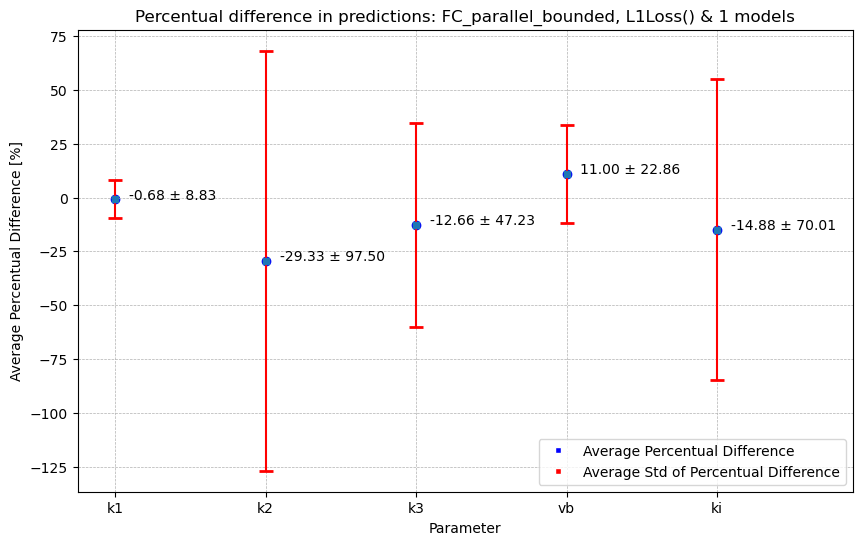

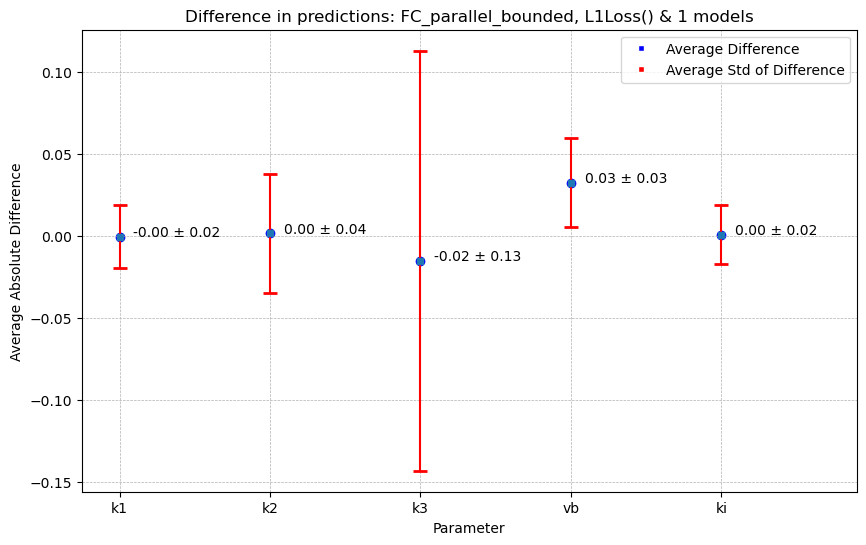

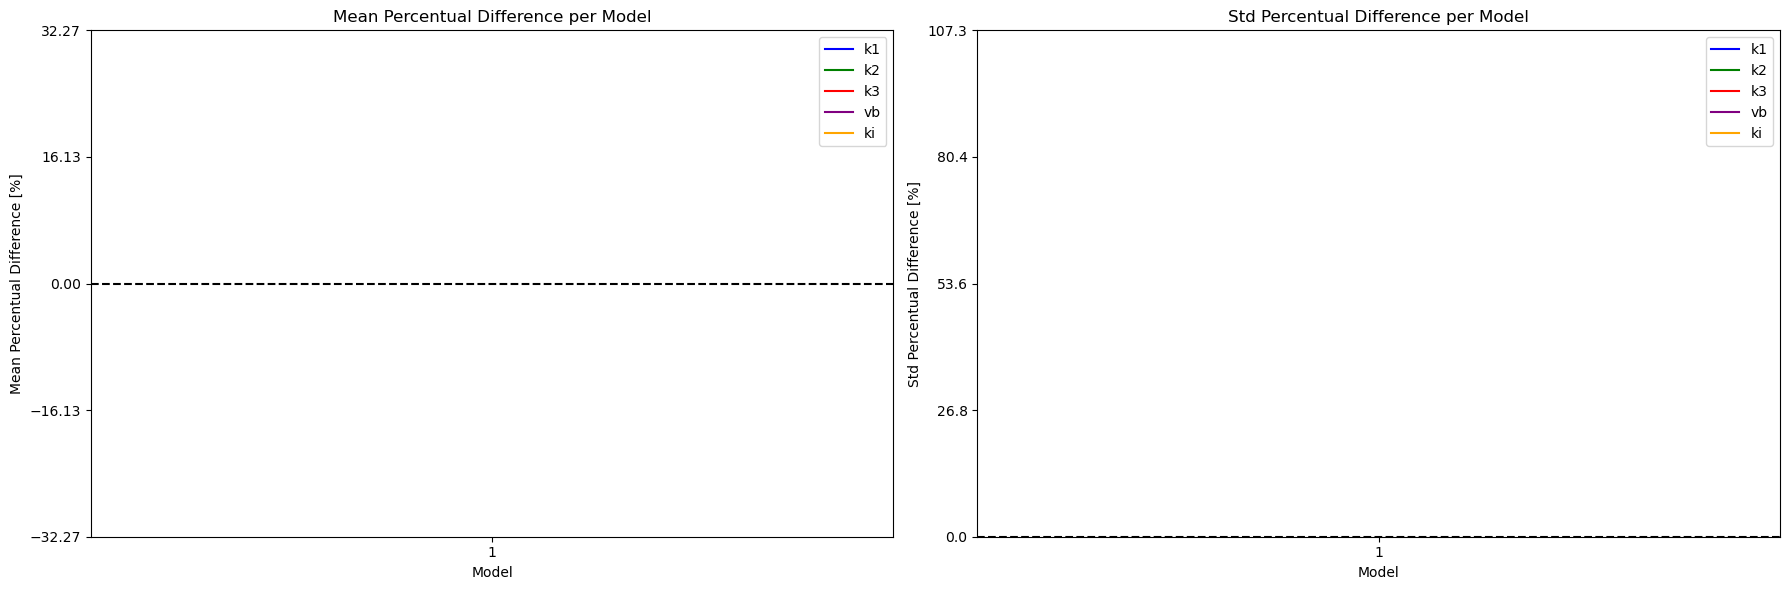

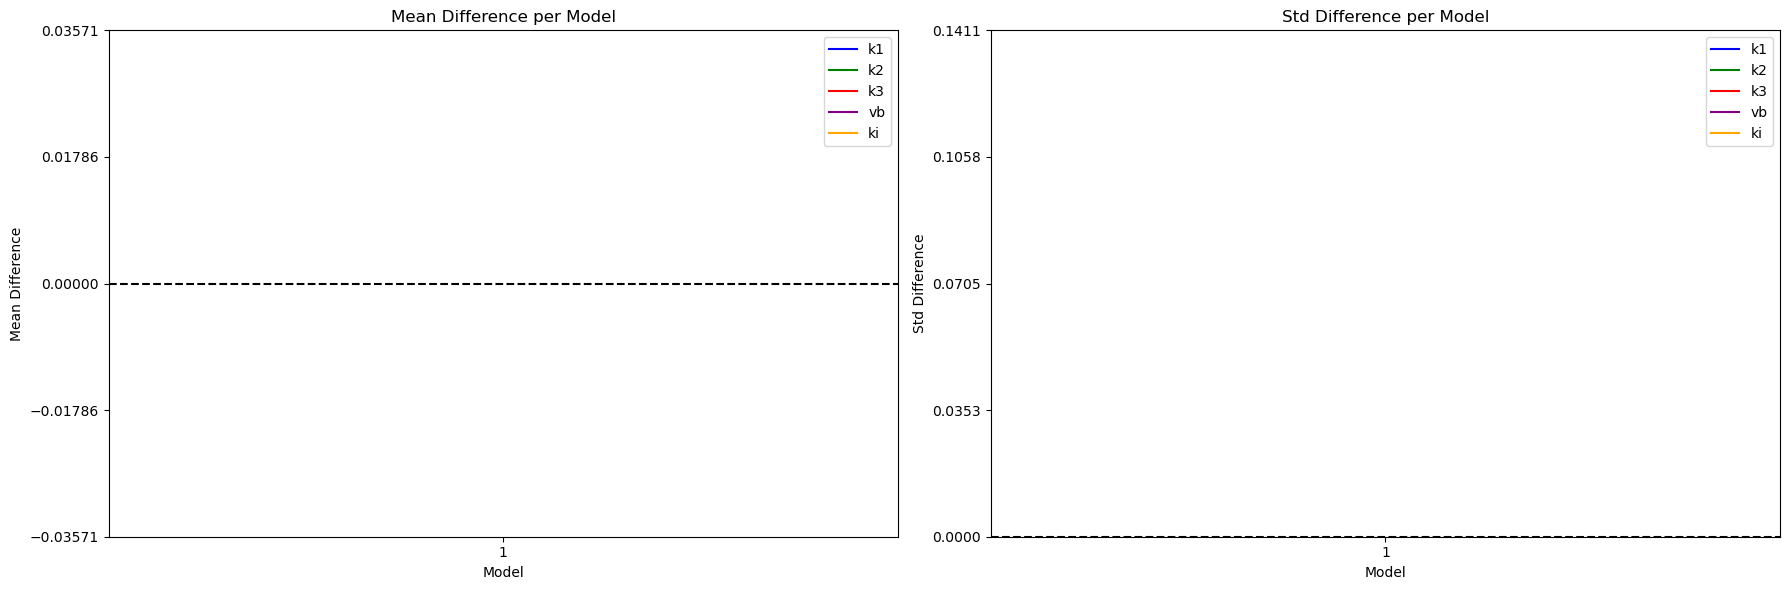

/Users/quimserrafaber/Desktop/Master AI/Thesis/Thesis_repo/source/Plots.py:290: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


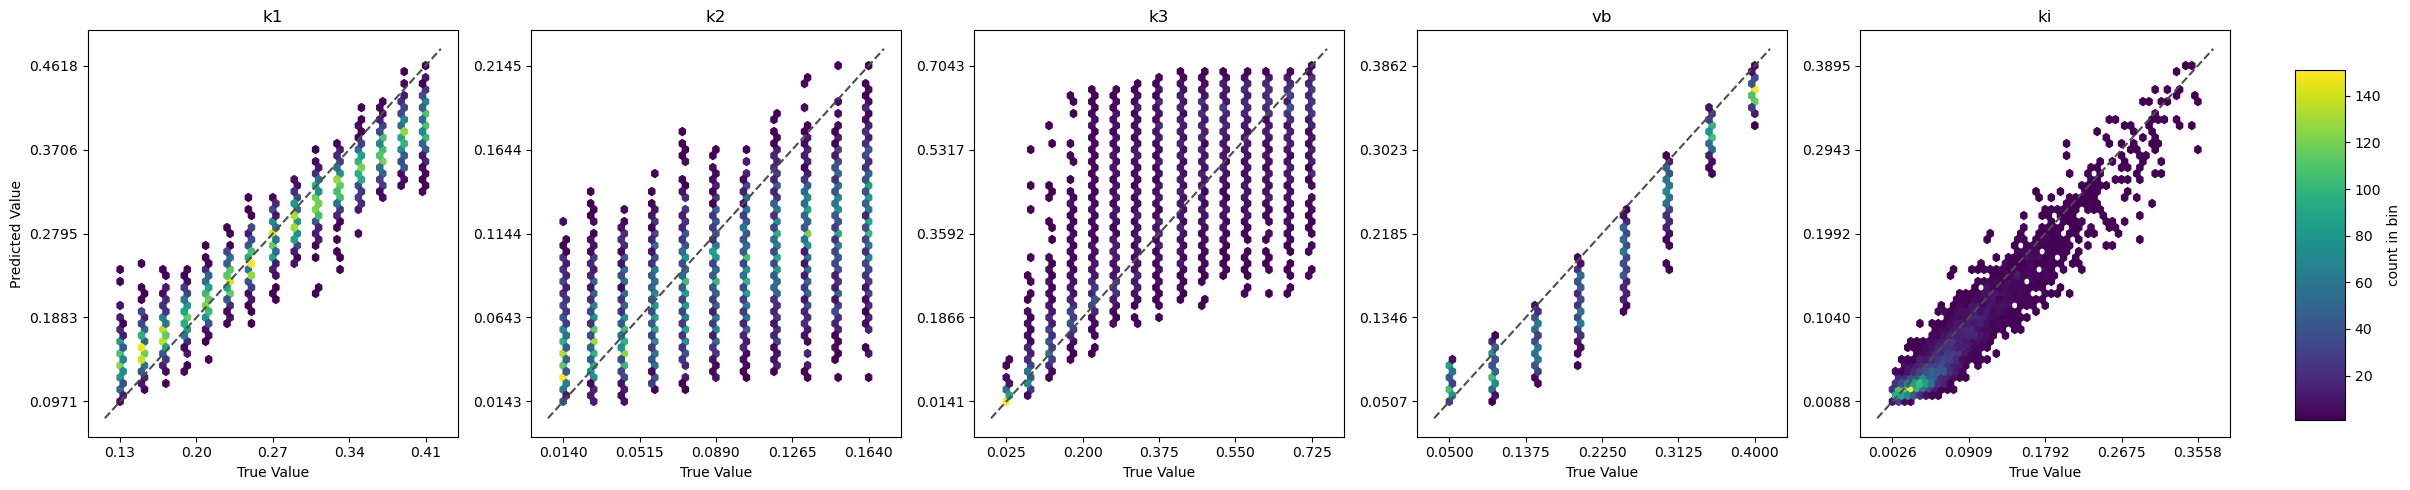

In [34]:
# Set the random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Load the data and define the loss function
#loss = nn.MSELoss()
loss = nn.L1Loss()
#loss = TAC_loss

config = { 
    'data': np.load("data/Generated_Data/simulation_simple_0.01.npz"),
    'model_class': FC_parallel_bounded,
    'loss_function': loss,
    'batch_size': 1024,
    'lr': 0.001,
    'patience': 3,
    'epochs': 50,
    'progress': True,
    'TAC_loss': False,
    'n_models': 1
}

# Initialize lists to collect the arrays
results_list = []
n_models = config['n_models']
for i in range(n_models):
    print(f"Training model {i + 1}")
    model, results = training_parallel_models(config)
    # Append the results
    results_list.append(results)

# Plot the mean and variance of the results
plot_mean_variance(results_list, config)
distribution_mean_std(results_list)
scatter_representation(results_list)

#cpu as device, tac loss: 1m 7.7s